In [1]:
import torch
import os
from scripts.utils.utils import summarize_attributions

In [2]:
integrated_gradients = "ig"
lime = "lime"
shap = "shap"

load = integrated_gradients
ds = "liar"

In [3]:
with torch.no_grad():
    models = {}
    for item in os.listdir(f"./pt/{ds}/{load}/"):
        models[item] = []
        for idx, pt in enumerate(os.listdir(f"./pt/{ds}/{load}/{item}")):
            pt: torch.Tensor = torch.load(f"./pt/{ds}/{load}/{item}/{pt}")[0]
            if load != integrated_gradients:
                models[item].append(pt.detach())
            else:
                models[item].append(summarize_attributions(pt.detach()))
models.keys()

dict_keys(['Llama-2-7b-chat-hf', 'Orca-2-7b', 'falcon-7b-instruct', 'Mistral-7B-Instruct-v0.2'])

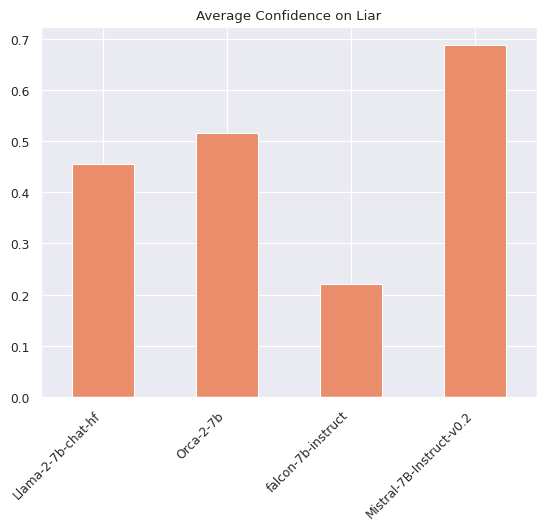

In [5]:
import seaborn as sns
import pandas
sns.set_theme("paper")
sns.set_palette(sns.color_palette("flare"))

if load == lime:
    meaned = {name: sum([i.abs().mean() for i in item])/len(item) for name, item in models.items()}
    df = pandas.DataFrame.from_dict({item: [val.item()] for item, val in meaned.items()})
    fig = df.mean().plot(kind="bar")
    fig.set_title(f"Average Tokenwise LIME attributions on {ds.title()}")
    fig.set_xticklabels(df.columns, rotation=45, ha='right')
elif load == integrated_gradients:
    summed = {name: sum([i.sum() for i in item])/len(item) for name, item in models.items()}
    df = pandas.DataFrame.from_dict({item: [val.item()] for item, val in summed.items()})
    fig = df.mean().plot(kind="bar")
    fig.set_title(f"Average Confidence on {ds.title()}")
    fig.set_xticklabels(df.columns, rotation=45, ha='right')


In [16]:
sns.set_theme(rc={"figure.figsize": (15, 4)})

In [17]:
# scale each one so that sum is 1
scaled_distplot_ready = {model: [(1 / attribution.sum())*attribution for attribution in attributions] for model, attributions in models.items()}

Text(0.5, 0, 'Token Contribution')

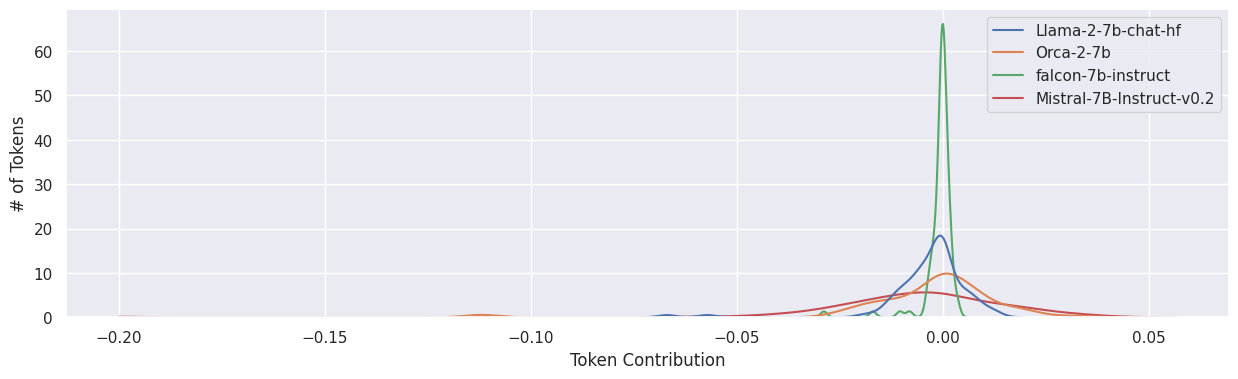

In [18]:
k = 2 # random.randint(0, len(models['falcon-7b-instruct']))
boxplots = sns.kdeplot({model: items[k]  for model, items in models.items()}, bw_adjust=.5, clip=(-.2, .2))
boxplots.set_ylabel("# of Tokens")
boxplots.set_xlabel("Token Contribution")

Text(0.5, 0, 'Token Contribution')

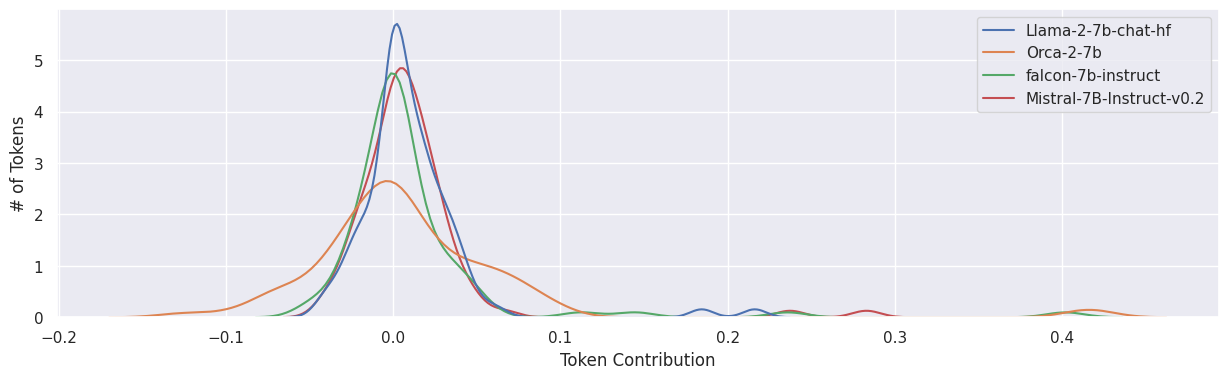

In [19]:
# k = random.randint(0, len(models['falcon-7b-instruct']))
boxplots = sns.kdeplot({model: items[k]  for model, items in scaled_distplot_ready.items()}, bw_adjust=.5)
boxplots.set_ylabel("# of Tokens")
boxplots.set_xlabel("Token Contribution")

In [20]:
scaled_concat = {model: torch.cat(item) for model, item in scaled_distplot_ready.items()}

Text(0.5, 0, 'LIME Aggregated Token Contributions')

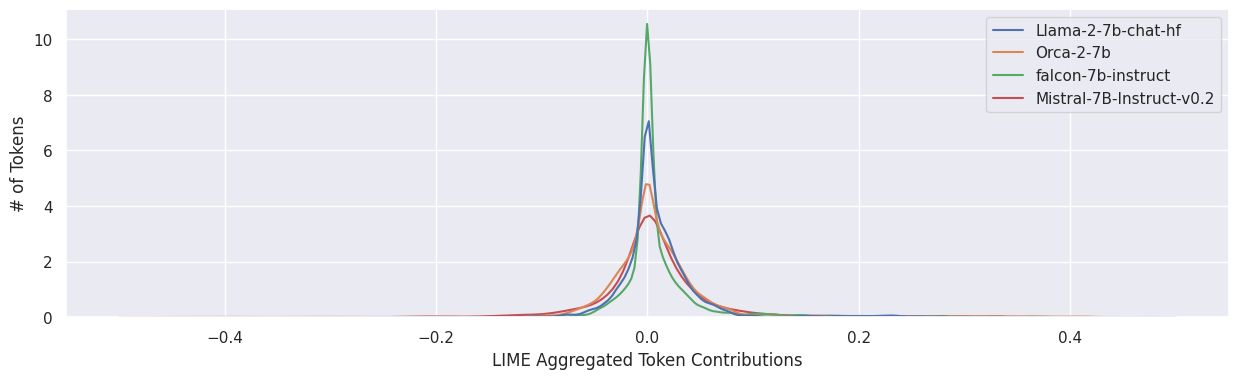

In [21]:
boxplots = sns.kdeplot(scaled_concat, bw_adjust=.5, clip=(-.5, .5))
boxplots.set_ylabel("# of Tokens")
boxplots.set_xlabel(f"{load.upper()} Aggregated Token Contributions")